In [1]:
import pickle
import spacy
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.dummy import DummyClassifier

In [2]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "textcat", "ner"])

In [3]:
df = pd.read_csv('../../data/df_w_r.csv', index_col = 0)

In [4]:
df.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery', 'type'],
      dtype='object')

In [5]:
df.shape

(32945, 14)

In [6]:
df

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,type
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,white
2,US,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,white
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,white
7,France,This dry and restrained wine offers spice in p...,Gewürztraminer,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,white
8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,white
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),white
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,white
129969,France,"A dry style of Pinot Gris, this is crisp with ...",Pinot Gris,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,white


In [7]:
def custom_tokenizer(text):
    '''
    used to filter out unwanted words, punctuation, and so on
    '''
    tokens = []
    for t in nlp(text):
        if not(len(t) < 2 or t.is_stop or t.like_num or 
               t.is_punct or not t.is_alpha):
            tokens.append(t.lemma_)
    return tokens 

In [8]:
corpus = df['description']

In [9]:
corpus

0         Aromas include tropical fruit, broom, brimston...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
7         This dry and restrained wine offers spice in p...
8         Savory dried thyme notes accent sunnier flavor...
                                ...                        
129965    While it's rich, this beautiful dry wine also ...
129966    Notes of honeysuckle and cantaloupe sweeten th...
129968    Well-drained gravel soil gives this wine its c...
129969    A dry style of Pinot Gris, this is crisp with ...
129970    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 32945, dtype: object

In [10]:
y = df['variety']

In [11]:
y.value_counts()

Chardonnay                    11753
Riesling                       5189
Sauvignon Blanc                4967
White Blend                    2360
Pinot Gris                     1455
Grüner Veltliner               1345
Portuguese White               1159
Bordeaux-style White Blend     1066
Pinot Grigio                   1052
Gewürztraminer                 1012
Viognier                        996
Chenin Blanc                    591
Name: variety, dtype: int64

In [12]:
bow = CountVectorizer(tokenizer=custom_tokenizer, 
                      ngram_range=(1, 1), 
                      min_df=0.01, 
                      max_df=0.99)

In [13]:
#with open('../../models/bern/bow.p', 'rb') as f:
#    bow = pickle.load(f)

In [14]:
#with open('../../models/bern/m.p', 'rb') as f:
#    m_nb = pickle.load(f)

In [15]:
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, 
                                                              test_size=0.4, 
                                                              train_size=0.6)

In [ ]:
X_train = bow.fit_transform(corpus_train)

In [ ]:
X_train.shape

In [ ]:
X_test = bow.transform(corpus_test)

In [ ]:
m_nb = Pipeline([
    ('TfIdf', TfidfTransformer()),
    ('DC', DummyClassifier())
])

In [ ]:
cross_val_score(m_nb, X_train, y_train, scoring='accuracy', n_jobs=4, cv=4).mean()

In [ ]:
m_nb.fit(X_train, y_train)

In [ ]:
pred = m_nb.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test, m_nb.predict(X_test))

In [ ]:
metrics.f1_score(y_test, pred, average='weighted')

In [128]:
m_nb.predict(bow.transform(['cherry flavor nice oak accent']))

array(['Chardonnay'], dtype='<U26')

In [129]:
m_nb.predict_proba(bow.transform(['cherry flavor nice oak accent'])).max()

0.3580555706734842

In [133]:
import sklearn
sklearn.__version__

'0.22.1'

In [41]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

confustion matrix
[[ 15   5   0 ...   0   0  16]
 [  0 970  11 ...   0   0  17]
 [  0   4 193 ...   1   8   0]
 ...
 [  1   0   0 ...  83  14   1]
 [  0   0  25 ...  20 489   0]
 [  3  13   0 ...   0   0 610]]


AttributeError: 'ConfusionMatrixDisplay' object has no attribute 'set_size_inches'

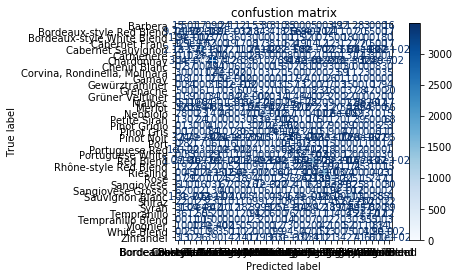

In [49]:
disp = plot_confusion_matrix(m_nb, X_test, y_test,
                            display_labels=m_nb.classes_,
                            cmap=plt.cm.Blues)
disp.ax_.set_title('confustion matrix')

print('confustion matrix')
print(disp.confusion_matrix)


plt.show()


In [130]:
with open('m_bern_w_r.p', 'wb') as f:
    pickle.dump(m_nb, f)

In [131]:
with open('bow_bern_w_r.p', 'wb') as f:
    pickle.dump(bow, f)